In [1]:
import sys  
sys.path.insert(0, "/".join(sys.path[0].split("/")[0:-2])+('/src'))
from sisal.solver import Solver
from sisal.utils import normalize_train_test_full_loader
from sisal.plot import Plot
import numpy as np
from pathlib import Path
from load_data import load
import argparse
import random
import torch

/Users/pldelacour/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = Path(r"../../data/VAN0046-LK-3-45-IMS_lipids_neg_roi=#1_mz=fix")
centroids, mask, mask_to_name, pixel_index = load(data_dir)
print('centroids = ',centroids.shape)
print('mask : ', mask.shape)
print('unique mask : ', np.unique(mask))

centroids =  (237642, 212)
mask :  (237642,)
unique mask :  [0. 1. 2. 3. 4. 5.]


In [3]:
train_loader, test_loader, full_index_loader = normalize_train_test_full_loader(centroids,mask,batch_size=32)

In [4]:
PATH = 'model_kidney.pth'

In [5]:
args = argparse.Namespace(
    beta=4, 
    z_dim=2, 
    epochs=40,
    device ='cpu',
    save_model_epochs=False,
    save_loss = False,
    train=True)
in_size = centroids.shape[1]

In [11]:
# For reproducibility 

# Set a fixed seed
seed = 302
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Ensures reproducibility across GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
net = Solver(args,in_size)

In [ ]:
net.train(train_loader, test_loader,PATH) 

### before epochs
EPOCH 1:
  batch 1000 loss: 86.94324417114258
  batch 2000 loss: 81.3584058303833
  batch 3000 loss: 80.70812065124511
  batch 4000 loss: 80.40071768951417
  batch 5000 loss: 80.14536657714844
LOSS train 80.14536657714844 valid 78.46765144168327
----------------Saving Model Epoch 1
EPOCH 2:
  batch 1000 loss: 79.47720792388915
  batch 2000 loss: 78.72076859664917
  batch 3000 loss: 78.64389065551758
  batch 4000 loss: 78.5105027770996
  batch 5000 loss: 78.43309662628174
LOSS train 78.43309662628174 valid 76.7804793746383
----------------Saving Model Epoch 2
EPOCH 3:
  batch 1000 loss: 78.03869450378419


In [ ]:
p = Plot(PATH,args.device,train_loader,test_loader,full_index_loader)
## Remove unlabeled pixels
mask0 = p.label!=0
p.full_latent = p.full_latent[mask0,:]
p.vars = p.vars[mask0,:]
p.label = p.label[mask0]

Compute Latent


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Using 47526 samples


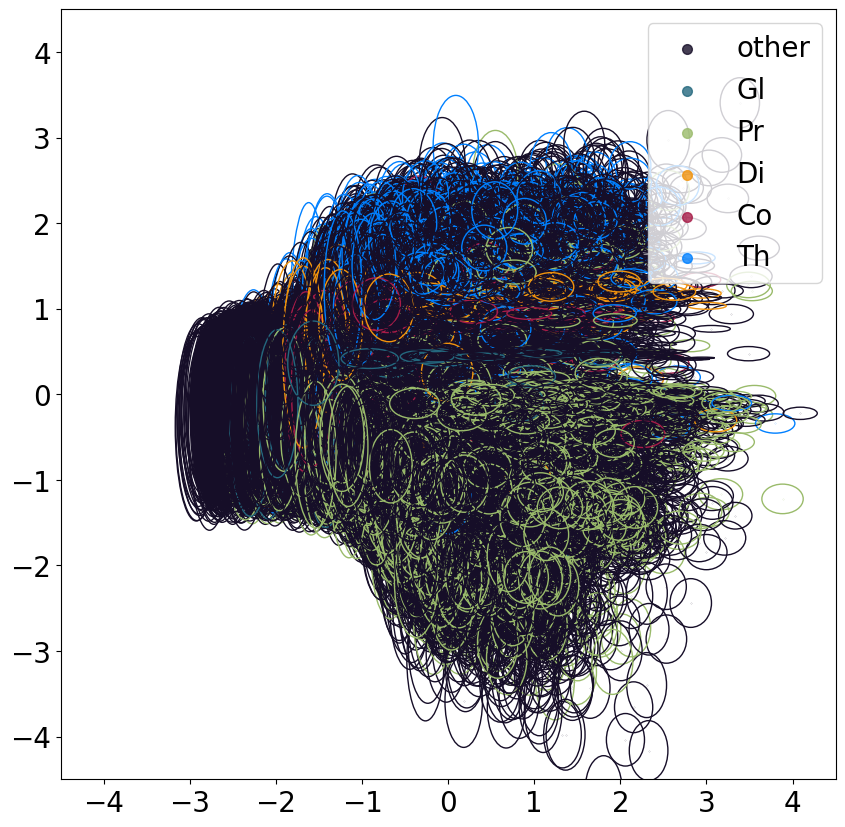

In [10]:
p.plot_latent_dim_with_var(mask_to_name,p=0.2)